# Exercise 4: Batch homology grouping and downstream QC analyses

Following on the same strategy we employed in exercises 1 and 2 of first learning how to employ `acute` on a single image and then scaling up to batch image data we will now take what we have learned in exercise 3 for homology grouping with the `starscape` and `constella` workflow and scale this method up for use on batch image data.  Following the generation of serial ID number homology groups and assigning them to our acute plms we will then assay the accuracy of these results through the use of a Quality Control (QC) test for `constella` and discuss how these outputs should be interpreted.

To begin lets load the libraries and other input files we'll need to proceed...

In [1]:
%matplotlib inline
# Change inline to widget for interactive plots
from plantcv import plantcv as pcv
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# PlantCV adjustable global parameters
pcv.params.debug = "plot"
pcv.params.text_size = 20
pcv.params.text_thickness = 10
pcv.params.line_thickness = 14
# Adjust plot sizes
pcv.params.dpi = 125

In [3]:
# Workflow parameters
win = 25
thresh = 90

path = './imgs'
days = range(10, 14)
name_prefix = 'B100_rep1_d'

outpath = './output'
os.makedirs(outpath, exist_ok=True)
outfile_prefix = os.path.join(outpath, 'B100_test')

Now with our libraries loaded and initial parameters assigned let us begin by running a batch workflow with `acute` to generate our list of plms as a landmark dataframe.



Contour volume: 2184.140382528305
Fusing contour edges
route C
Landmark site: 1841, Start site: 1819, Term. site: 21
Landmark point indices: [1841]
Starting site indices: [1819]
Termination site indices: [21]
route C
Landmark site: 308, Start site: 284, Term. site: 333
Landmark point indices: [1841, 308]
Starting site indices: [1819, 284]
Termination site indices: [21, 333]
route C
Landmark site: 553, Start site: 528, Term. site: 577
Landmark point indices: [1841, 308, 553]
Starting site indices: [1819, 284, 528]
Termination site indices: [21, 333, 577]
route C
Landmark site: 883, Start site: 869, Term. site: 894
Landmark point indices: [1841, 308, 553, 883]
Starting site indices: [1819, 284, 528, 869]
Termination site indices: [21, 333, 577, 894]
route C
Landmark site: 976, Start site: 948, Term. site: 1001
Landmark point indices: [1841, 308, 553, 883, 976]
Starting site indices: [1819, 284, 528, 869, 948]
Termination site indices: [21, 333, 577, 894, 1001]
route C
Landmark site: 1110

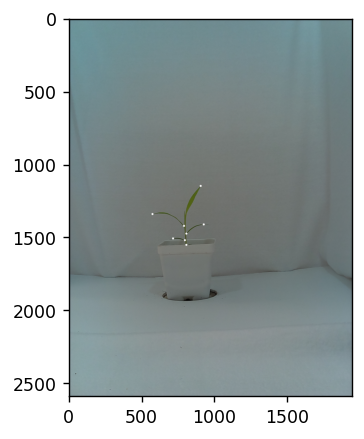

    landmark number: 8
Contour volume: 2436.750554203987
Fusing contour edges
route C
Landmark site: 2070, Start site: 2047, Term. site: 18
Landmark point indices: [2070]
Starting site indices: [2047]
Termination site indices: [18]
route C
Landmark site: 265, Start site: 241, Term. site: 289
Landmark point indices: [2070, 265]
Starting site indices: [2047, 241]
Termination site indices: [18, 289]
route C
Landmark site: 401, Start site: 377, Term. site: 428
Landmark point indices: [2070, 265, 401]
Starting site indices: [2047, 241, 377]
Termination site indices: [18, 289, 428]
route C
Landmark site: 598, Start site: 574, Term. site: 620
Landmark point indices: [2070, 265, 401, 598]
Starting site indices: [2047, 241, 377, 574]
Termination site indices: [18, 289, 428, 620]
route C
Landmark site: 839, Start site: 816, Term. site: 862
Landmark point indices: [2070, 265, 401, 598, 839]
Starting site indices: [2047, 241, 377, 574, 816]
Termination site indices: [18, 289, 428, 620, 862]
route 

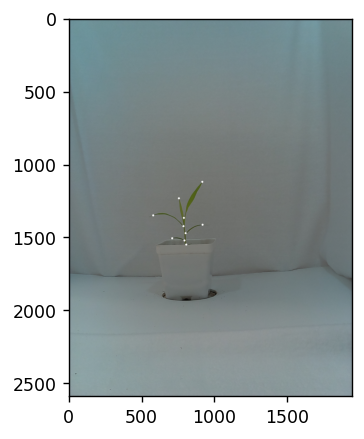

    landmark number: 10
Contour volume: 2664.7160643339157
Fusing contour edges
route C
Landmark site: 0, Start site: 2242, Term. site: 21
Landmark point indices: [0]
Starting site indices: [2242]
Termination site indices: [21]
route C
Landmark site: 280, Start site: 258, Term. site: 303
Landmark point indices: [0, 280]
Starting site indices: [2242, 258]
Termination site indices: [21, 303]
route C
Landmark site: 494, Start site: 472, Term. site: 519
Landmark point indices: [0, 280, 494]
Starting site indices: [2242, 258, 472]
Termination site indices: [21, 303, 519]
route C
Landmark site: 773, Start site: 750, Term. site: 799
Landmark point indices: [0, 280, 494, 773]
Starting site indices: [2242, 258, 472, 750]
Termination site indices: [21, 303, 519, 799]
route C
Landmark site: 1008, Start site: 988, Term. site: 1031
Landmark point indices: [0, 280, 494, 773, 1008]
Starting site indices: [2242, 258, 472, 750, 988]
Termination site indices: [21, 303, 519, 799, 1031]
route C
Landmark s

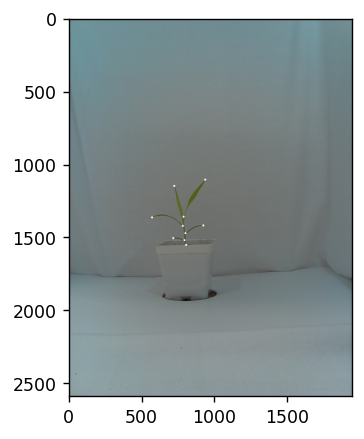

    landmark number: 10
Contour volume: 2932.647084593773
Fusing contour edges
route C
Landmark site: 0, Start site: 2442, Term. site: 22
Landmark point indices: [0]
Starting site indices: [2442]
Termination site indices: [22]
route C
Landmark site: 358, Start site: 333, Term. site: 386
Landmark point indices: [0, 358]
Starting site indices: [2442, 333]
Termination site indices: [22, 386]
route C
Landmark site: 595, Start site: 573, Term. site: 617
Landmark point indices: [0, 358, 595]
Starting site indices: [2442, 333, 573]
Termination site indices: [22, 386, 617]
route C
Landmark site: 926, Start site: 905, Term. site: 943
Landmark point indices: [0, 358, 595, 926]
Starting site indices: [2442, 333, 573, 905]
Termination site indices: [22, 386, 617, 943]
route C
Landmark site: 1004, Start site: 978, Term. site: 1027
Landmark point indices: [0, 358, 595, 926, 1004]
Starting site indices: [2442, 333, 573, 905, 978]
Termination site indices: [22, 386, 617, 943, 1027]
route C
Landmark si

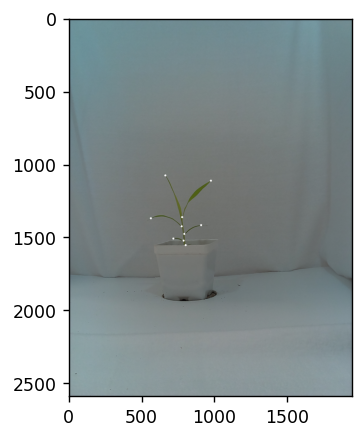

    landmark number: 10


In [4]:
landmark_output=[['group', 'plmname', 'filename', 'plm_x', 'plm_y', 'SS_x', 'SS_y', 'TS_x', 'TS_y', 'CC_ratio']]
for day in days:
    # Turn off debugging outputs for most steps to avoid a huge amount of output
    pcv.params.debug = None
    # 1. Reading our image into the environment
    img, imgpath, imgname = pcv.readimage(filename=os.path.join(path, f"{name_prefix}{day}.jpg"))
    
    # 2. Converting our RGB image into an Lab color space and extract the a and b channels
    img_a = pcv.rgb2gray_lab(rgb_img=img, channel="a")
    img_b = pcv.rgb2gray_lab(rgb_img=img, channel="b")
    
    # 3. Thresholding our a and b color channels to create two masks
    mask_a = pcv.threshold.binary(gray_img=img_a, threshold=123, max_value=255, object_type="dark")
    mask_b = pcv.threshold.binary(gray_img=img_b, threshold=133, max_value=255, object_type="light")
    
    # 4. Merging our individual a and b thresholded masks
    mask = pcv.logical_and(bin_img1=mask_a, bin_img2=mask_b)
    
    # 5. Extracting our contours from the final mask
    cnt, cnt_str = pcv.find_objects(img=img, mask=mask)
    
    # 6. Find largest contour of subject (outer boundary of subject)
    roi, roi_str = pcv.roi.rectangle(img=img, x=500, y=500, h=1100, w=800)
    kept_cnt, kept_str, kept_mask, kept_area = pcv.roi_objects(img=img, roi_contour=roi, roi_hierarchy=roi_str, 
                                                               object_contour=cnt, obj_hierarchy=cnt_str, roi_type="largest")
    
    # 7. Extracting pseudo-landmarks from the plant contours
    plt_img = np.copy(img)
    for cont in kept_cnt:
        if cv2.arcLength(cont, True) > 2*win:
            print(f'Contour volume: {cv2.arcLength(cont, True)}')
            # Turn debugging back on for acute
            pcv.params.debug = "plot"
            homolog_pts, homolog_start, homolog_stop, homolog_cc, chain, verbose = pcv.homology.acute(img=img, obj=cont, mask=mask,
                                                                                                      win=win, threshold=thresh)
            print(f'    landmark number: {len(homolog_pts)}')

            for h in range(0, len(homolog_pts)):
                landmark_output.append([None, f"{name_prefix}{day}_plm{h+1}", f"{name_prefix}{day}", homolog_pts[h][0][0], homolog_pts[h][0][1], 
                                        homolog_start[h][0][0], homolog_start[h][0][1], homolog_stop[h][0][0], homolog_stop[h][0][1], homolog_cc[h],])

# Convert out output to a pandas dataframe for ease of use hereafter...
landmark_pandas = pd.DataFrame(landmark_output[1:len(landmark_output)], columns=landmark_output[0][0:11])

Before we continue lets check our landmarks once more to ensure we'll have what we need to run our homology grouping workflow...

In [5]:
landmark_pandas.head()

,group,plmname,filename,plm_x,plm_y,SS_x,SS_y,TS_x,TS_y,CC_ratio
0,None,B100_rep1_d10_plm1,B100_rep1_d10,901,1151,892,1173,885,1167,255.000000
1,None,B100_rep1_d10_plm2,B100_rep1_d10,787,1425,789,1401,773,1405,6.219512
2,None,B100_rep1_d10_plm3,B100_rep1_d10,571,1344,594,1338,595,1342,255.000000
3,None,B100_rep1_d10_plm4,B100_rep1_d10,793,1523,796,1511,783,1519,18.888889
4,None,B100_rep1_d10_plm5,B100_rep1_d10,712,1511,736,1508,736,1512,255.000000


In [6]:
landmark_pandas.to_csv("/Users/nfahlgren/GitHub/plantcv/tests/data/plms_annotated.csv", index=True)

Provided the head of our table loaded in properly we're now ready to begin a batch run of our homology pipeline which follows the same structure as our previous exercise utilizing `starscape` and `constella`. Note that we have left out `space` from this workflow, studies of this pipelines accuracy have suggested that this function isn't essential for generating tangible improvements in homology grouping.  As such this workflow of parsing segmented morphological data directly into `starscape` is considered the present best practice of this approach. Notice how our groups within `landmark_pandas` are universally assigned to 'None'? On the other side of this code block we should see the results of transfering group IDs from paired frames to this original dataframe resulting in forthcoming changes to this columns values.  Let's get started! 


######################################################
Beginning next iteration for days 10 and 11
Running StarScape...
Eigenvalues:  [3.74069468 2.73593046 0.92648202 0.00523252] 


Var. Explained:  [0.5046969  0.36913348 0.12500154 0.00070597] 


Cumul. Var. Explained:  [0.5046969  0.87383038 0.99883192 0.99953789] 


2  components sufficiently informative


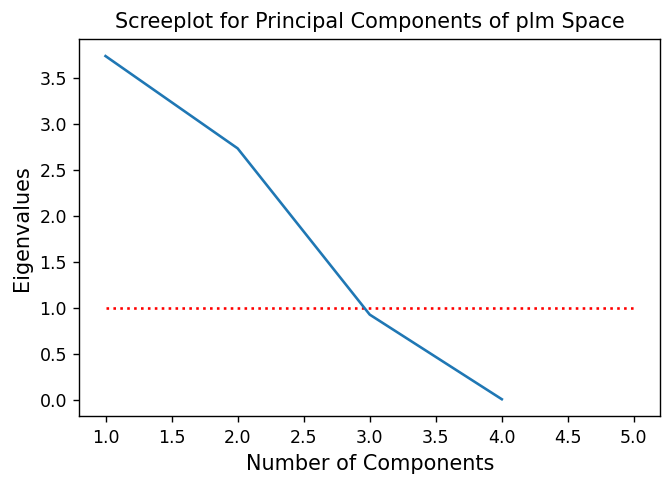

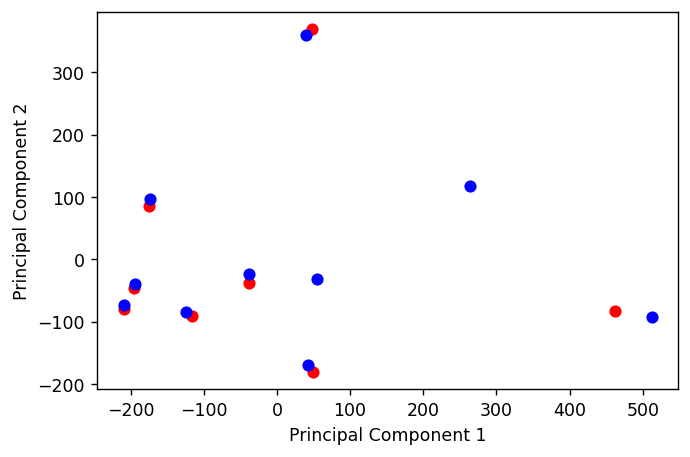

Running Constella...
18 plms to group


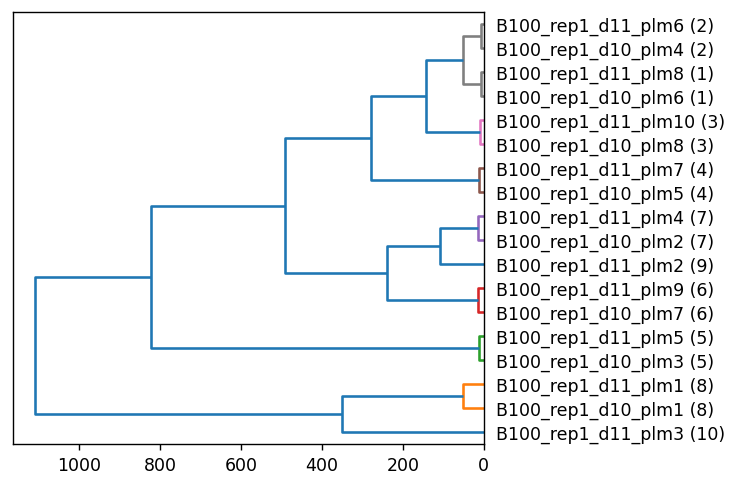

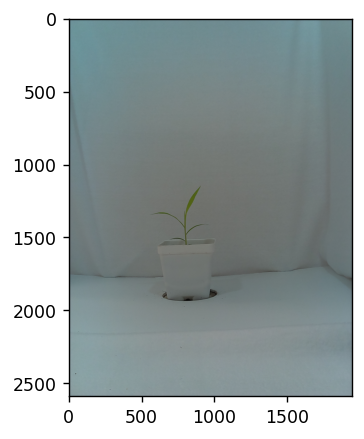

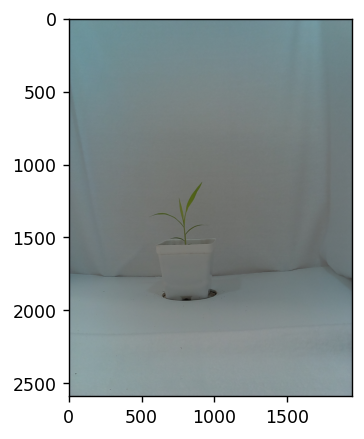

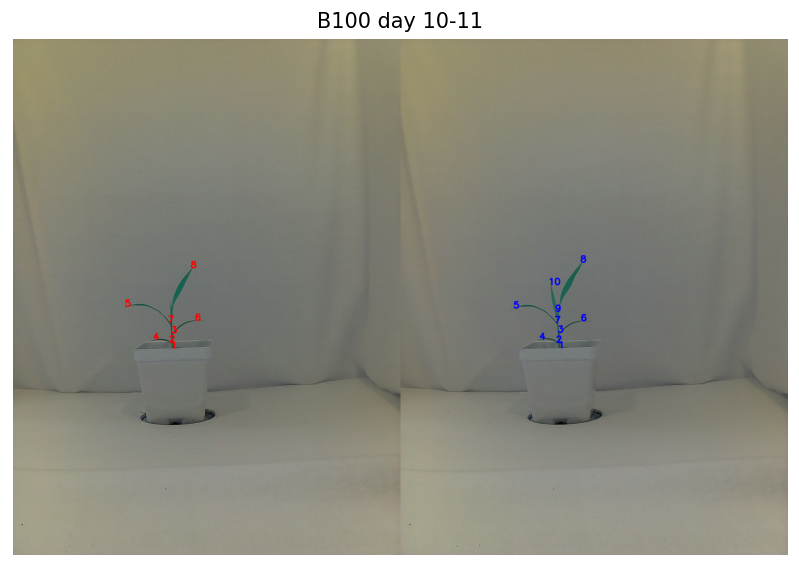

######################################################
Beginning next iteration for days 11 and 12
Running StarScape...
Eigenvalues:  [3.70796764 2.74004966 0.91203917 0.00514027] 


Var. Explained:  [0.50322418 0.37186388 0.12377674 0.00069761] 


Cumul. Var. Explained:  [0.50322418 0.87508806 0.99886481 0.99956241] 


2  components sufficiently informative


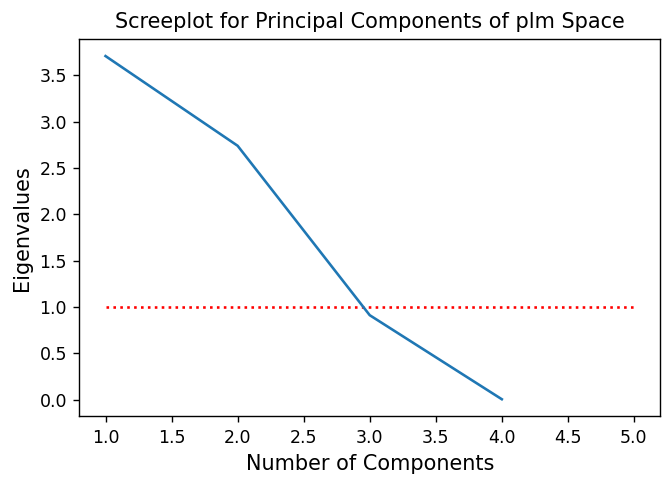

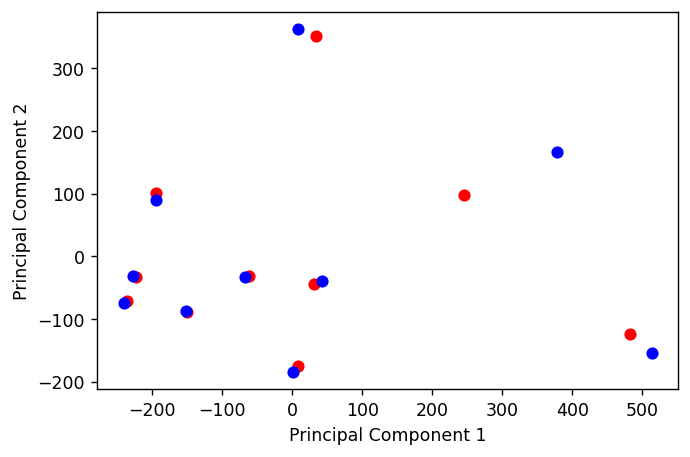

Running Constella...
20 plms to group


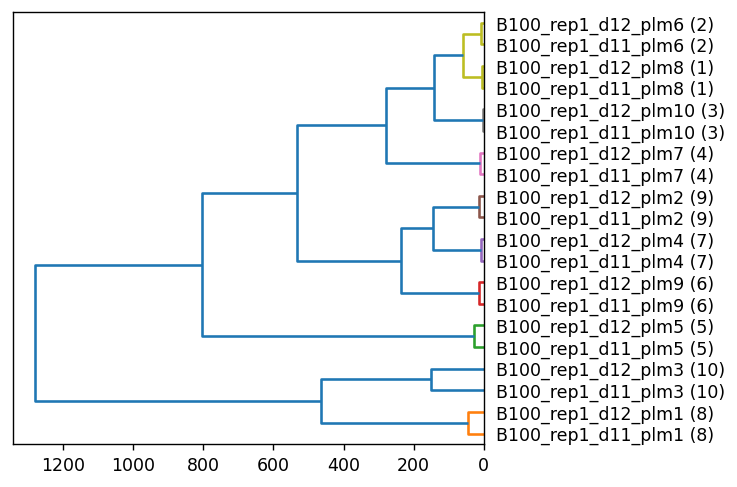

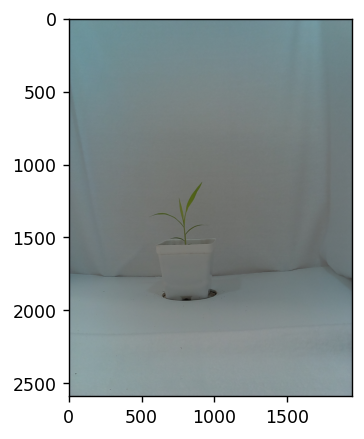

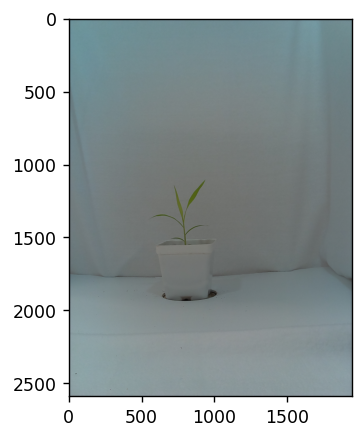

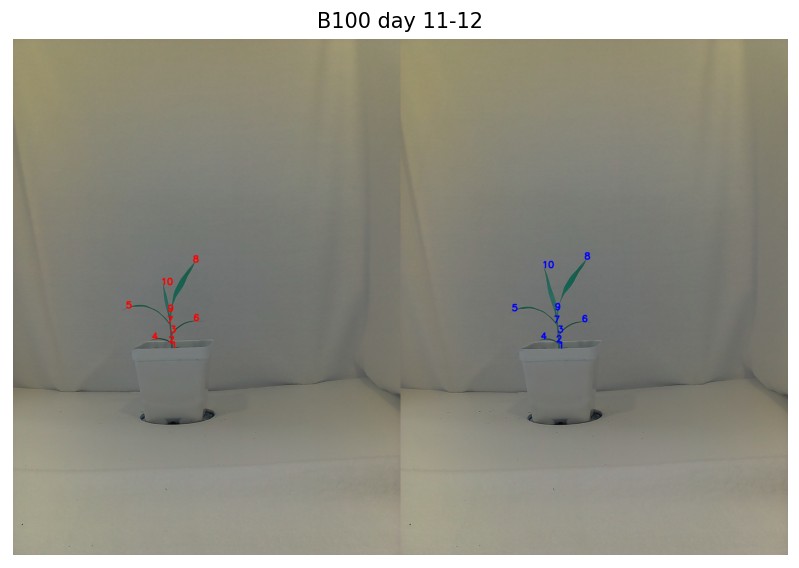

######################################################
Beginning next iteration for days 12 and 13
Running StarScape...
Eigenvalues:  [3.5310468  2.93567762 0.89436779 0.00450095] 


Var. Explained:  [0.47921349 0.39841339 0.12137849 0.00061084] 


Cumul. Var. Explained:  [0.47921349 0.87762689 0.99900537 0.99961622] 


2  components sufficiently informative


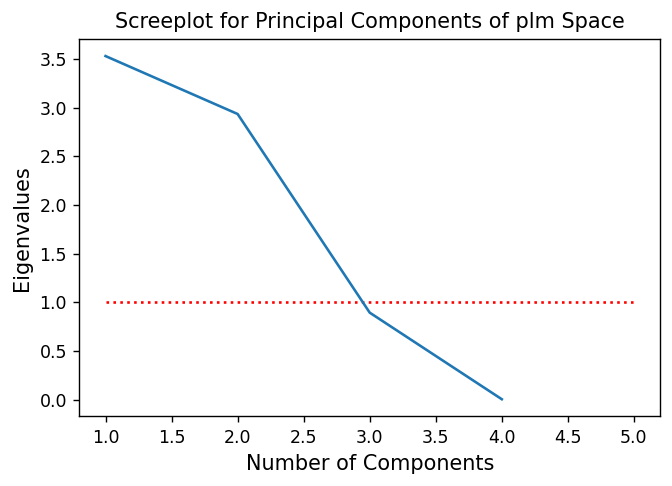

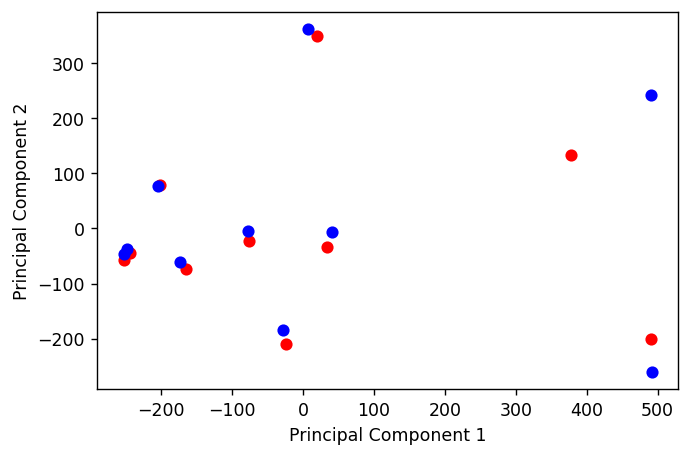

Running Constella...
20 plms to group


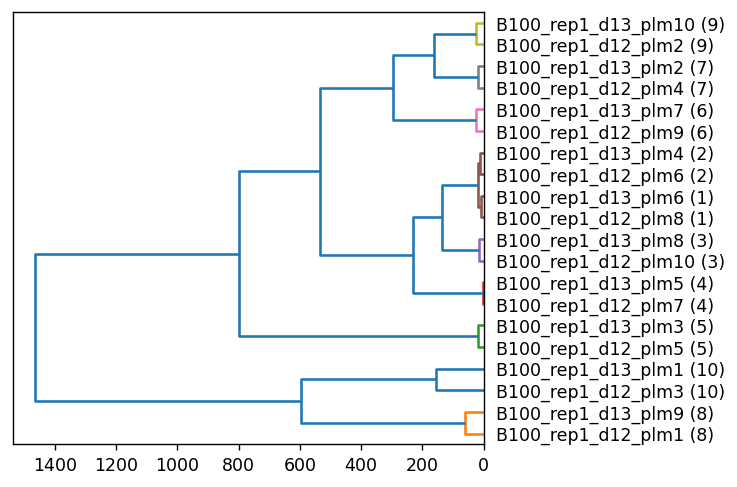

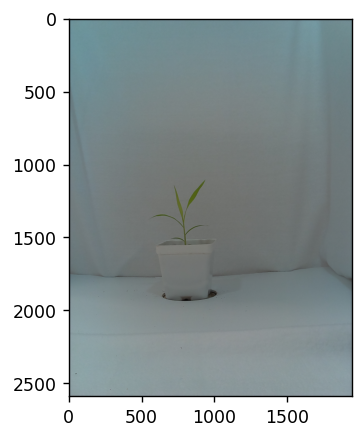

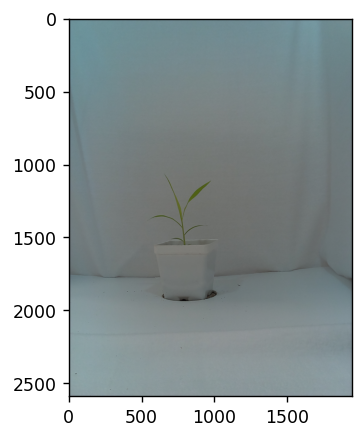

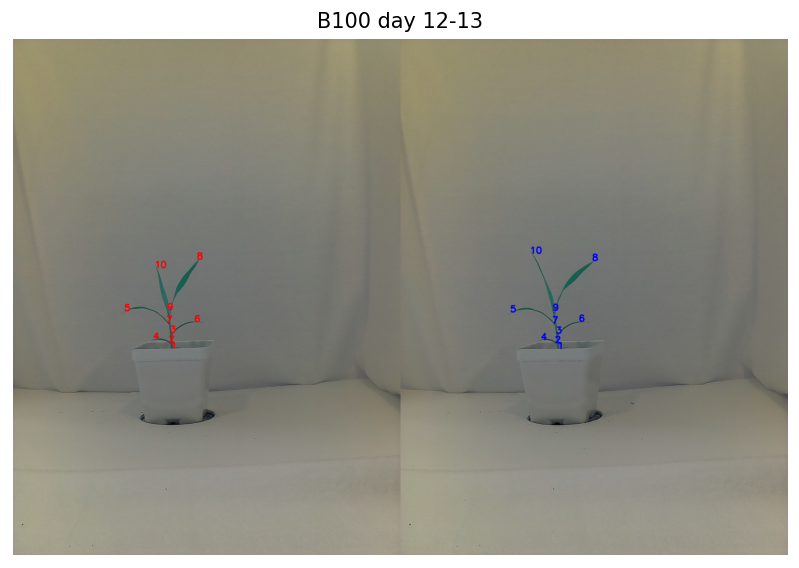

In [7]:
group_iter = 1
# Get all the filenames from the dataframe for filtering
filenames = landmark_pandas.loc[:,['filename']].values
# Loop over the days we defined above
for day in days[:-1]:
    # Iteration is between day and day + 1
    print("######################################################")
    print(f'Beginning next iteration for days {day} and {day + 1}')
    
    # Current data frame of pseudo-landmarks from the pair of day and day + 1
    groupA = f"{name_prefix}{day}"
    groupB = f"{name_prefix}{day + 1}"
    cur_plms = landmark_pandas[filenames == groupA]
    cur_plms = cur_plms.append(landmark_pandas[filenames == groupB])
    cur_plms = cur_plms.reset_index(drop=True)
    
    print('Running StarScape...')
    finalDf, eigenvals, loadings = pcv.homology.starscape(cur_plms=cur_plms, group_a=groupA, group_b=groupB, outfile_prefix=f"{outfile_prefix}_{day}")
    
    print('Running Constella...')
    cur_plms, group_iter = pcv.homology.constella(cur_plms=cur_plms, pc_starscape=finalDf, group_iter=group_iter, outfile_prefix=f"{outfile_prefix}_{day}")
    
    plmnames = landmark_pandas.loc[:,['plmname']].values
    cur_plmnames = cur_plms.loc[:,['plmname']].values
    
    for name in cur_plmnames:
        landmark_index = [i for i, x in enumerate(plmnames == name) if x]
        cur_plms_index = [i for i, x in enumerate(cur_plmnames == name) if x]
        if landmark_pandas.iloc[landmark_index, 0].values == None:
            landmark_pandas.iloc[landmark_index, 0] = cur_plms.iloc[cur_plms_index, 0]
    
    img1, _, _ = pcv.readimage(filename=os.path.join(path, f"{name_prefix}{day}.jpg"))
    
    for p in range(0, cur_plms.shape[0]):
        if f"{name_prefix}{day}" in cur_plms.at[p, 'plmname']:        
            cv2.putText(img1, str(cur_plms.at[p, 'group']), 
                        (int(cur_plms.at[p, 'plm_x'])-10, int(cur_plms.at[p, 'plm_y'])), 
                        cv2.FONT_ITALIC, 1.5, (255,0,0), 6)
    
    img2, _, _ = pcv.readimage(filename=os.path.join(path, f"{name_prefix}{day + 1}.jpg"))

    for p in range(0, cur_plms.shape[0]):
        if f"{name_prefix}{day + 1}" in cur_plms.at[p, 'plmname']:        
            cv2.putText(img2, str(cur_plms.at[p, 'group']), 
                        (int(cur_plms.at[p, 'plm_x'])-10, int(cur_plms.at[p, 'plm_y'])), 
                        cv2.FONT_ITALIC, 1.5, (0,0,255), 6)
    img_neighbors = cv2.hconcat((img1, img2))

    plm_groups_fig=plt.figure(figsize=(8, 6))
    plm_groups_fig=plt.imshow(img_neighbors)
    plm_groups_fig=plt.xscale('linear')
    plm_groups_fig=plt.axis('off')
    plm_groups_fig=plt.title(f'B100 day {day}-{day + 1}')
    plt.show(plm_groups_fig)
    

With the homology grouping workflow now completed a decent array of graphical outputs should be visible above displaying not only our PCA related graphs and the dendrogram used for our hierarchical clustering at each step, but also side by side images of our plants as well as their labeled homology groups to enable for easy point of reference for calling accuracy.  Let's have a look at our de novo homology groups on our original `landmark_pandas` dataframe, this time we'll have a look at the full table though instead of just taking a quick glance at the head.


In [8]:
landmark_pandas

,group,plmname,filename,plm_x,plm_y,SS_x,SS_y,TS_x,TS_y,CC_ratio
0,8,B100_rep1_d10_plm1,B100_rep1_d10,901,1151,892,1173,885,1167,255.000000
1,7,B100_rep1_d10_plm2,B100_rep1_d10,787,1425,789,1401,773,1405,6.219512
2,5,B100_rep1_d10_plm3,B100_rep1_d10,571,1344,594,1338,595,1342,255.000000
3,2,B100_rep1_d10_plm4,B100_rep1_d10,793,1523,796,1511,783,1519,18.888889
4,4,B100_rep1_d10_plm5,B100_rep1_d10,712,1511,736,1508,736,1512,255.000000
5,1,B100_rep1_d10_plm6,B100_rep1_d10,803,1555,795,1533,807,1532,255.000000
6,6,B100_rep1_d10_plm7,B100_rep1_d10,922,1415,898,1420,898,1416,255.000000
7,3,B100_rep1_d10_plm8,B100_rep1_d10,803,1478,816,1459,801,1454,12.207447
8,8,B100_rep1_d11_plm1,B100_rep1_d11,912,1123,904,1146,895,1139,255.000000
9,9,B100_rep1_d11_plm2,B100_rep1_d11,786,1370,794,1347,784,1346,0.000000


We see group serial numbers 1-10 repeating once for each frame so it appears things ran pretty well! Moreover, when we glance at the side-by-side images with the serial numbers superimposed onto the original images things look like they're grouping as we'd expect.  

However, as with all de novo methods there is the possibility for errors to be introduced which we might miss at a glance.  This brings us to a key aspect of our plm workflow when scaling up to a full sized project which is Quality Control (QC) assessment of our de novo homologies.  This is often done with a reduced subset of our full dataset in order to give us a general idea of the overall accuracy of our calls.  Although there is currently one method of producing input `starscape` files to feeding to `constella` eventually as other ways to rescale our `acute` outputs are developed this method can provide a helpful means of comparing what method of metadata generation (plmSpace) and multivariate space transformation (`starscape`) is the best for maximizing biologically informative signal.  With this being said let's begin by loading in a table of our landmarks which have been annotated to represent the biological structures they represent*.

*Although not seen in this situation it is common practice to denote random plms which don't represent any meaningful features as '-'.*


In [9]:
landmark_feat_standards = pd.read_csv('B100_timeseries_test_plms_annotated.csv')
landmark_feat_standards.head(10)

,group,plmname,filename,plm_x,plm_y,SS_x,SS_y,TS_x,TS_y,CC_ratio
0,leaf5,B100_rep1_d10_plm1,B100_rep1_d10,901,1151,892,1173,885,1167,255.000000
1,ligule4,B100_rep1_d10_plm2,B100_rep1_d10,787,1425,789,1401,773,1405,6.219512
2,leaf4,B100_rep1_d10_plm3,B100_rep1_d10,571,1344,594,1338,595,1342,255.000000
3,ligule2,B100_rep1_d10_plm4,B100_rep1_d10,793,1523,796,1511,783,1519,18.888889
4,leaf2,B100_rep1_d10_plm5,B100_rep1_d10,712,1511,736,1508,736,1512,255.000000
5,base,B100_rep1_d10_plm6,B100_rep1_d10,803,1555,795,1533,807,1532,255.000000
6,leaf3,B100_rep1_d10_plm7,B100_rep1_d10,922,1415,898,1420,898,1416,255.000000
7,ligule3,B100_rep1_d10_plm8,B100_rep1_d10,803,1478,816,1459,801,1454,12.207447
8,leaf5,B100_rep1_d11_plm1,B100_rep1_d11,912,1123,904,1146,895,1139,255.000000
9,ligule5,B100_rep1_d11_plm2,B100_rep1_d11,786,1370,794,1347,784,1346,0.000000


After glancing at the table above we essentially have 3 types of features we're classifying, our leaf tips denoted as 'leaf', our axils where leaf blades attach to the stem as 'ligule' (common term for this feature in grasses), and 'base' which represents the bottom landmark at the base of our plant.  Now we have a list of known features which we can compare to our corresponding list of our predicted homology groups.


In [10]:
pcv.homology.constellaqc(denovo_groups=landmark_pandas, annotated_groups=landmark_feat_standards)

Known Feature-Predicted Group Scoring Matrix:

         1   2   3   4   5   6   7   8   9   10
base      4   0   0   0   0   0   0   0   0   0
leaf2     0   0   0   4   0   0   0   0   0   0
leaf3     0   0   0   0   0   4   0   0   0   0
leaf4     0   0   0   0   4   0   0   0   0   0
leaf5     0   0   0   0   0   0   0   4   0   0
leaf6     0   0   0   0   0   0   0   0   0   3
ligule2   0   4   0   0   0   0   0   0   0   0
ligule3   0   0   4   0   0   0   0   0   0   0
ligule4   0   0   0   0   0   0   4   0   0   0
ligule5   0   0   0   0   0   0   0   0   3   0


Valid Call Rate:      100.0 %
Splitting Call Rate:  0.0 %
Clumping Call Rate:   0.0 %


And there we have it! As expected the valid calls were perfect within this tutorial although error, and importantly the type of error is important to keep track of when developing this workflow for your own research.  To provide a bit of context let's discuss what our two sources of error represent.

## Splitting Error

Splitting errors are essentially calls in which more than one de novo homology group was generated to represent a single, known, feature.  Within this workflow these errors are often considered less egregious given that they can easily be reconciled together during manual curation of homology groups prior to using plm homology groups for morphometric analyses.  A good analogy to this problem is that of scaffold generation during whole genome sequencing in which often only fragments of rather than complete chromosomes are reconstructed from the data.  This issue is easily reconciled by a user specifying that these two scaffolds belong together and manually assigning linkage based on known attributes of this data which exist beyond the capacity of the de novo assembler.  In a similar vein of logic, if a leaf tip is broken into two groups it can easily be tied together as these groups are given a biologically relevant name.

## Clumping Error

Clumping errors by contrast are calls in which multiple known features are linked together under a single de novo homology group.  Understandably this error is considered far more troubling and all efforts in designing this workflow have been to drive this error rate as low as possible (in most cases hovering in the 5% range for true experimental data).  Often datasets which have a high degree of parallax (possessing perspective related artifacts of compressing 3-dimensional structures into a 2-dimensional frame) tend to drive up this error rate.  It is often best to check this error rate under a reduced dataset of each genotype or environmental treatment that is anticipated to be used given that it can provide a user with an overall grasp of how well Constella's de novo assignments work within this pool of the data.  Cases in which clumping error rates are higher may require a more stringent round of manual curration in order to ensure that morphometric analyses performed on this data afterwards are meaningful.


# In Conclusion

And there you have it! We've successfully started with a handful of time series images and learned how to prepare binary masks which can be used for acute in Tutorial 1.  We then learned in Tutorial 2 how to scale up what we had learned in our first exercise to work on batch image datasets. Following the generation of this batch plm data we were then able to explore de novo homology grouping through the use of our StarScape & Constella pipeline in Tutorial 3. And finally in our last exercise we again scaled up what we learned for homology grouping on to batch datasets then were able to test what we generated using ConstellaQC in order to get a general idea of how much confidence we can have in our calls.  

I hope this tutorial series have been informative and provides you with some quick-start code to get your own projects running. Cheers!